# GRU 계층 구현

## 라이브러리 호출

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 데이터 가져오기

In [2]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # chap07/data/SUBX.csv 데이터 불러오기
data=pd.read_csv('SBUX.csv')
print(data.dtypes)

Saving SBUX.csv to SBUX.csv
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


## 데이터 전처리

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
data['Volume'] = data['Volume'].astype(float) # 데이터 추후에 텐서로 변환할때 편리함

In [5]:
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [6]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200,:]
X_test = X_ss[200:,:]

y_train = y_ms[:200,:]
y_test = y_ms[200:,:]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


## 데이터셋의 형태 및 크기 조정

In [7]:
# Variable에 감싸져 있으면 역전파할때(.backward()) 자동으로 기울기 계산됨
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],1, X_train_tensors.shape[1]))
X_test_tensors_f =  torch.reshape(X_test_tensors, (X_test_tensors.shape[0],1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


## GRU 네트워크

In [12]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전연결층
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉 상태를 0으로 초기화
        # LSTM에서는 셀상태를 정의하지만 GRU에서는 셀 상태를 정의하지 않음
        ouput, (hn) = self.gru(x, (h_0)) # GRU 계층에 은닉 상태 적용
        hn = hn.view(-1, self.hidden_size) # 완전연결층 적용을 위해 데이터의 형태 조정(1차원으로 조정)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out


## 변수 값 설정

In [13]:
num_epochs = 1000
learning_rate = 1e-3

input_size = 5 # 입력데이터셋의 칼럼(feature) 개수
hidden_size = 2 # 은긱층의 뉴런/유닛 개수
num_layers = 1 # GRU 계층의 개수
num_classes = 1 # 클래수의 개수

model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) # GRU모델 학습

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

##  모델 학습

In [14]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f) # 전방향 학습
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors) # 손실함수를 이용한 오차계산
    loss.backward()

    optimizer.step() # 오차 업데이터
    if epoch % 100 == 0:
        print("Epoch: %d, loss %1.5f" %(epoch, loss.item()))

Epoch: 0, loss 0.05910
Epoch: 100, loss 0.01755
Epoch: 200, loss 0.01674
Epoch: 300, loss 0.01592
Epoch: 400, loss 0.01492
Epoch: 500, loss 0.01372
Epoch: 600, loss 0.01300
Epoch: 700, loss 0.01263
Epoch: 800, loss 0.01225
Epoch: 900, loss 0.01182


## 모델 예측 결과를 출력하기 위한 데이터크기 재구성

In [15]:
df_x_ss = ss.transform(data.iloc[:,:-1])
df_y_ms = ms.transform(data.iloc[:,-1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0],1,df_x_ss.shape[1]))

## 모델 예측 결과 출력

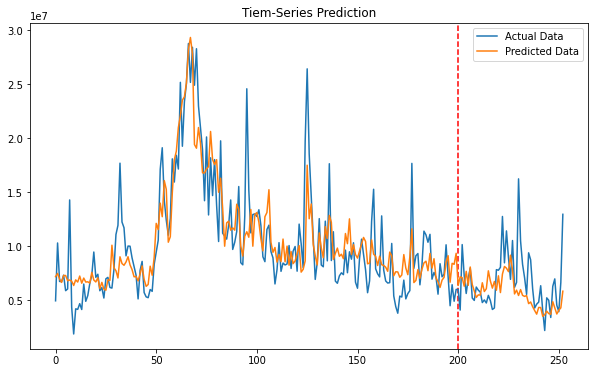

In [16]:
train_predict = model(df_x_ss) # 훈련데이터셋을 모델에 적용하여 모델 학습
predicted = train_predict.data.numpy() # 모델 학습결과를 넘파이로 변경
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted) # 모델학습을 위해 전처리(정규화)했던 것을 해제 (그래프의 본래 값을 출력하기 위한 목적)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Tiem-Series Prediction')
plt.legend()
plt.show()